In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "YABBY"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn002711,MEIRRSKEVSVPCTSLFKTVTVRCGHCTNLLPVNMRGLLLPSTNQL...,213,1
1,Achn019201,MRCHVPVDELPMTCHKMVDMRTGQGTCSDGTKHFLVMDCGTTLCLG...,312,1
2,Achn032281,MRFMIHLQSKQEVSPELEADAEKGLDKRSPSLVISSDDEDDDEVPV...,104,1
3,Achn088151,MRGLLPPSANQLHLGHAFFSPQNLLEDIQNSSPNLLINHPNPNGLV...,309,1
4,Achn155211,MDLVPPPEQLCYVRCNFCNTVLAGFVNEIKKGQSSSSSSSTSSEPV...,73,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
591,0.009524,0.000000,0.000000,0.000000,0.004762,0.004762,0.004762,0.000000,0.009524,0.000000,...,0.004762,0.000000,0.000000,0.000000,0.000000,0.000000,0.004762,0.0,0.0,0.000000
1717,0.076023,0.000000,0.000000,0.000000,0.011696,0.011696,0.005848,0.000000,0.005848,0.000000,...,0.000000,0.005848,0.005848,0.000000,0.000000,0.005848,0.000000,0.0,0.0,0.000000
2228,0.001420,0.004261,0.004261,0.011364,0.002841,0.001420,0.001420,0.004261,0.004261,0.004261,...,0.000000,0.001420,0.000000,0.002841,0.000000,0.002841,0.002841,0.0,0.0,0.000000
3094,0.000000,0.000000,0.000000,0.000000,0.003155,0.000000,0.000000,0.000000,0.003155,0.000000,...,0.000000,0.003155,0.003155,0.006309,0.000000,0.003155,0.000000,0.0,0.0,0.006309
2575,0.009479,0.000000,0.000000,0.004739,0.000000,0.000000,0.000000,0.004739,0.014218,0.000000,...,0.004739,0.000000,0.000000,0.000000,0.004739,0.000000,0.000000,0.0,0.0,0.000000


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2726, 441)
X_test: (682, 441)
y_train: (2726,)
y_test: (682,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 21s 633ms/step - accuracy: 0.4531 - loss: 0.6930

30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7138 - loss: 0.6730   

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7336 - loss: 0.6622 - val_accuracy: 0.9524 - val_loss: 0.3316


Epoch 2/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9688 - loss: 0.3286

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9720 - loss: 0.2224 

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9727 - loss: 0.2151 - val_accuracy: 0.9762 - val_loss: 0.0731


Epoch 3/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.1598

31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9869 - loss: 0.0650 

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9871 - loss: 0.0633 - val_accuracy: 0.9799 - val_loss: 0.0547


Epoch 4/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9531 - loss: 0.1220

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9872 - loss: 0.0451 

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9876 - loss: 0.0441 - val_accuracy: 0.9853 - val_loss: 0.0404


Epoch 5/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0046

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9921 - loss: 0.0277 

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9923 - loss: 0.0275 - val_accuracy: 0.9835 - val_loss: 0.0361


Epoch 6/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9688 - loss: 0.0447

27/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9899 - loss: 0.0283 

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9906 - loss: 0.0276 - val_accuracy: 0.9853 - val_loss: 0.0456


Epoch 7/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0060

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0181 

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9939 - loss: 0.0184 - val_accuracy: 0.9853 - val_loss: 0.0531


Epoch 8/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0081

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0186 

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0181 - val_accuracy: 0.9835 - val_loss: 0.0433


Epoch 9/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0016

27/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0106 

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0111 - val_accuracy: 0.9817 - val_loss: 0.0493


Epoch 10/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0024

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0166 

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0151 - val_accuracy: 0.9817 - val_loss: 0.0509


Epoch 11/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0021

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0138 

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0129 - val_accuracy: 0.9817 - val_loss: 0.0543


Epoch 12/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0014

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0056 

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0067 - val_accuracy: 0.9835 - val_loss: 0.0589


Epoch 13/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0060

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 0.0031 

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0044 - val_accuracy: 0.9780 - val_loss: 0.0617


Epoch 14/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0019

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0069 

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0068 - val_accuracy: 0.9817 - val_loss: 0.0595



[Train Accuracy: 99.91% - Test Accuracy: 99.12%]


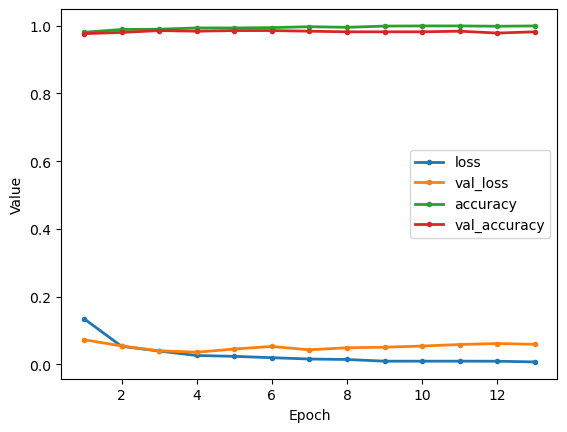

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
591,0.004785,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.004785,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1717,0.047059,0.0,0.0,0.000000,0.0,0.005882,0.0,0.0,0.005882,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2228,0.000000,0.0,0.0,0.001422,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3094,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.003165,0.0,0.0,0.0,0.0,0.0,0.0
2575,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (2726, 8567)
X_test: (682, 8567)
y_train: (2726,)
y_test: (682,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,193,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,236,673 (8.53 MB)

 Trainable params: 2,236,673 (8.53 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 22s 655ms/step - accuracy: 0.4375 - loss: 0.6932

 8/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6149 - loss: 0.6914   

16/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7149 - loss: 0.6856

24/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7708 - loss: 0.6745

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8093 - loss: 0.6527

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8189 - loss: 0.6439 - val_accuracy: 0.9835 - val_loss: 0.1492


Epoch 2/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9844 - loss: 0.1654

 9/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9879 - loss: 0.1261 

18/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9864 - loss: 0.1080

26/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9862 - loss: 0.0982

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9866 - loss: 0.0891

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9866 - loss: 0.0883 - val_accuracy: 0.9963 - val_loss: 0.0187


Epoch 3/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0052

 9/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0071 

17/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9990 - loss: 0.0098

26/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9988 - loss: 0.0096

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9987 - loss: 0.0097

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9987 - loss: 0.0098 - val_accuracy: 0.9982 - val_loss: 0.0170


Epoch 4/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0060

 9/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0074 

18/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0064

27/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0055

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0049 - val_accuracy: 0.9963 - val_loss: 0.0213


Epoch 5/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0011

 9/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.2939e-04

17/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.6610e-04

25/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011    

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0012

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9963 - val_loss: 0.0185


Epoch 6/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 9.5942e-04

 9/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.4316e-04 

17/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.8555e-04

25/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.6464e-04

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.7745e-04

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.7761e-04 - val_accuracy: 0.9963 - val_loss: 0.0228


Epoch 7/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 5.1094e-04

 9/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.7383e-04 

17/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.6010e-04

26/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.5932e-04

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.5562e-04

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5463e-04 - val_accuracy: 0.9927 - val_loss: 0.0273


Epoch 8/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.6224e-04

 9/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0064e-04 

17/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8563e-04

25/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7842e-04

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7859e-04

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7891e-04 - val_accuracy: 0.9945 - val_loss: 0.0271


Epoch 9/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 8.9749e-05

10/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3952e-04 

18/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2996e-04

26/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1708e-04

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0630e-04

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0400e-04 - val_accuracy: 0.9927 - val_loss: 0.0292


Epoch 10/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.3040e-04

 9/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.5140e-05 

17/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.4200e-05

25/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.2721e-05

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.9144e-05

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.7857e-05 - val_accuracy: 0.9927 - val_loss: 0.0319


Epoch 11/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 5.8333e-05

10/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.8926e-05 

19/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.7429e-05

27/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.9634e-05

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.9159e-05 - val_accuracy: 0.9927 - val_loss: 0.0319


Epoch 12/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 5.6385e-05

 9/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.3937e-05 

17/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.8254e-05

25/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2088e-04

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2949e-04

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3041e-04 - val_accuracy: 0.9963 - val_loss: 0.0250


Epoch 13/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 4.4326e-05

 9/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.3539e-05 

17/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0068e-04

25/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0252e-04

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0109e-04

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0175e-04 - val_accuracy: 0.9927 - val_loss: 0.0322



[Train Accuracy: 100.00% - Test Accuracy: 99.41%]


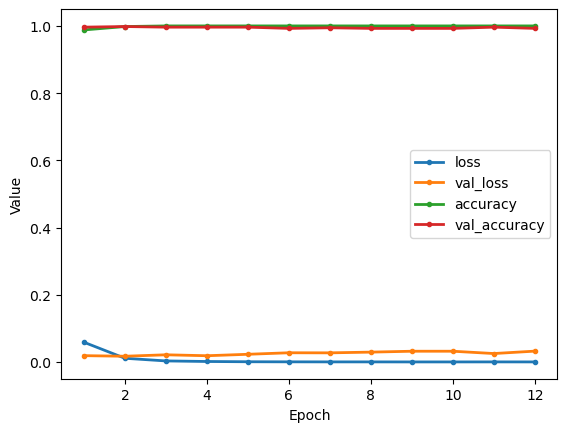

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
591,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004808,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1717,0.035503,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005917,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2228,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3094,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2575,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      32,634,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,676,097 (124.65 MB)

 Trainable params: 32,676,097 (124.65 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 28s 848ms/step - accuracy: 0.4688 - loss: 0.6932

 2/35 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.4688 - loss: 0.6931  

 3/35 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.4826 - loss: 0.6930

 4/35 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.4811 - loss: 0.6930

 5/35 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.4880 - loss: 0.6929

 6/35 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.5009 - loss: 0.6928

 7/35 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.5164 - loss: 0.6926

 8/35 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.5331 - loss: 0.6925

 9/35 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5493 - loss: 0.6922

10/35 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5650 - loss: 0.6920

11/35 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5799 - loss: 0.6917

12/35 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5938 - loss: 0.6914

13/35 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.6068 - loss: 0.6910

14/35 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.6188 - loss: 0.6906

15/35 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.6298 - loss: 0.6902

16/35 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.6401 - loss: 0.6897

17/35 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.6497 - loss: 0.6892

18/35 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.6586 - loss: 0.6887

19/35 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.6670 - loss: 0.6881

20/35 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.6748 - loss: 0.6875

21/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.6823 - loss: 0.6868

22/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6894 - loss: 0.6860

23/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6962 - loss: 0.6852

24/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7026 - loss: 0.6843

25/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7086 - loss: 0.6834

26/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7143 - loss: 0.6824

27/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7197 - loss: 0.6814

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7249 - loss: 0.6802

29/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7298 - loss: 0.6791

30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7346 - loss: 0.6778

31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7391 - loss: 0.6764

32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7435 - loss: 0.6750

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7477 - loss: 0.6734

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7518 - loss: 0.6718

35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.7592 - loss: 0.6688 - val_accuracy: 0.9872 - val_loss: 0.3599


Epoch 2/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 7s 228ms/step - accuracy: 0.9531 - loss: 0.3634

 2/35 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9648 - loss: 0.3545 

 3/35 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.9714 - loss: 0.3453

 4/35 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.9756 - loss: 0.3374

 5/35 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9767 - loss: 0.3321

 6/35 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9767 - loss: 0.3276

 7/35 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9772 - loss: 0.3223

 8/35 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.9773 - loss: 0.3173

 9/35 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.9773 - loss: 0.3125

10/35 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9774 - loss: 0.3074

11/35 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9777 - loss: 0.3021

12/35 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.9780 - loss: 0.2967

13/35 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9783 - loss: 0.2914

14/35 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9786 - loss: 0.2862

15/35 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9788 - loss: 0.2812

16/35 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9789 - loss: 0.2764

17/35 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9791 - loss: 0.2717

18/35 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9794 - loss: 0.2670

19/35 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9796 - loss: 0.2625

20/35 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9798 - loss: 0.2582

21/35 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9799 - loss: 0.2540

22/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9801 - loss: 0.2498

23/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9804 - loss: 0.2458

24/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9806 - loss: 0.2419

25/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9808 - loss: 0.2381

26/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9810 - loss: 0.2344

27/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9812 - loss: 0.2308

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9814 - loss: 0.2274

29/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9816 - loss: 0.2240

30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9818 - loss: 0.2208

31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9820 - loss: 0.2177

32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9822 - loss: 0.2147

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9823 - loss: 0.2118

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9825 - loss: 0.2090

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9828 - loss: 0.2039 - val_accuracy: 0.9963 - val_loss: 0.0159


Epoch 3/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 1.0000 - loss: 0.0071

 2/35 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 1.0000 - loss: 0.0098 

 3/35 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9983 - loss: 0.0118

 4/35 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.9977 - loss: 0.0125

 5/35 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.9976 - loss: 0.0126

 6/35 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9975 - loss: 0.0125

 7/35 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.9976 - loss: 0.0124

 8/35 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.9976 - loss: 0.0124

 9/35 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9977 - loss: 0.0123

10/35 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9978 - loss: 0.0121

11/35 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9978 - loss: 0.0120

12/35 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9979 - loss: 0.0119

13/35 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9980 - loss: 0.0118

14/35 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9980 - loss: 0.0117

15/35 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9981 - loss: 0.0116

16/35 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9982 - loss: 0.0115

17/35 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9982 - loss: 0.0113

18/35 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9983 - loss: 0.0112

19/35 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9983 - loss: 0.0111

20/35 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9983 - loss: 0.0111

21/35 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.9983 - loss: 0.0110

22/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9983 - loss: 0.0109

23/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9983 - loss: 0.0109

24/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9983 - loss: 0.0108

25/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9984 - loss: 0.0107

26/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9984 - loss: 0.0106

27/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9984 - loss: 0.0105

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9984 - loss: 0.0104

29/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9984 - loss: 0.0104

30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9984 - loss: 0.0103

31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9985 - loss: 0.0102

32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9985 - loss: 0.0101

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9985 - loss: 0.0100

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9985 - loss: 0.0100

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.9985 - loss: 0.0098 - val_accuracy: 0.9963 - val_loss: 0.0088


Epoch 4/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 0.0042

 2/35 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - accuracy: 1.0000 - loss: 0.0039 

 3/35 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 1.0000 - loss: 0.0035

 4/35 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 1.0000 - loss: 0.0033

 5/35 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 1.0000 - loss: 0.0031

 6/35 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 1.0000 - loss: 0.0029

 7/35 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 1.0000 - loss: 0.0028

 8/35 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 1.0000 - loss: 0.0027

 9/35 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 1.0000 - loss: 0.0026

10/35 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0025

11/35 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 0.0025

12/35 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 0.0024

13/35 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 1.0000 - loss: 0.0024

14/35 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 0.0024

15/35 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 0.0023

16/35 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 0.0023

17/35 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 0.0023

18/35 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 0.0022

19/35 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 1.0000 - loss: 0.0022

20/35 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 0.0022

21/35 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 0.0021

22/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0021

23/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0021

24/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0021

25/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0020

26/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0020

27/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0020

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0020

29/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0020

30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0019

31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0019

32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0019

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0019

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0019

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9963 - val_loss: 0.0097


Epoch 5/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 1.0000 - loss: 0.0013

 2/35 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 1.0000 - loss: 0.0012

 3/35 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 1.0000 - loss: 0.0011

 4/35 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 0.0011

 5/35 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 0.0010

 6/35 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 9.9846e-04

 7/35 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 9.6764e-04

 8/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 9.4692e-04

 9/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 9.2929e-04

10/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 9.1436e-04

11/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 9.0025e-04

12/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 8.8764e-04

13/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 8.7699e-04

14/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 8.6740e-04

15/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 8.5951e-04

16/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 8.5185e-04

17/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 8.4370e-04

18/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 8.3555e-04

19/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 8.3111e-04

20/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 8.2903e-04

21/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 8.2694e-04

22/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 8.2442e-04

23/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 8.2160e-04

24/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 8.1850e-04

25/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 8.1519e-04

26/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 8.1148e-04

27/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 8.0766e-04

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 8.0358e-04

29/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 7.9955e-04

30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 7.9548e-04

31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 7.9189e-04

32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 7.8814e-04

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 7.8435e-04

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 7.8058e-04

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 1.0000 - loss: 7.7360e-04 - val_accuracy: 0.9963 - val_loss: 0.0109


Epoch 6/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 1.0000 - loss: 7.6802e-04

 2/35 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 6.4805e-04

 3/35 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 5.8247e-04

 4/35 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 5.4545e-04

 5/35 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 5.3808e-04

 6/35 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 5.2929e-04

 7/35 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 5.2416e-04

 8/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 5.1718e-04

 9/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 5.1137e-04

10/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 5.1077e-04

11/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 5.1010e-04

12/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 5.0901e-04

13/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 5.0681e-04

14/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 5.0597e-04

15/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 5.0454e-04

16/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 5.0333e-04

17/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 5.0193e-04

18/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 5.0041e-04

19/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 4.9869e-04

20/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 4.9736e-04

21/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 4.9539e-04

22/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 4.9330e-04

23/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 4.9130e-04

24/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 4.8998e-04

25/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 4.8981e-04

26/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 4.9064e-04

27/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 4.9180e-04

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 4.9266e-04

29/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 4.9333e-04

30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 4.9378e-04

31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 4.9407e-04

32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 4.9410e-04

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 4.9392e-04

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 4.9373e-04

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 1.0000 - loss: 4.9333e-04 - val_accuracy: 0.9963 - val_loss: 0.0100


Epoch 7/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 1.0000 - loss: 2.3079e-04

 2/35 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 3.2274e-04

 3/35 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 1.0000 - loss: 3.4469e-04

 4/35 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 3.6309e-04

 5/35 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 3.6438e-04

 6/35 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 3.6435e-04

 7/35 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 3.6703e-04

 8/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 3.6784e-04

 9/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 3.6612e-04

10/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 3.6419e-04

11/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 3.6267e-04

12/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 3.6125e-04

13/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 3.5925e-04

14/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 3.5807e-04

15/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 3.5633e-04

16/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 3.5453e-04

17/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 3.5263e-04

18/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 3.5145e-04

19/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 3.5010e-04

20/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 3.4885e-04

21/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 3.4722e-04

22/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 3.4547e-04

23/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 3.4472e-04

24/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 3.4384e-04

25/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 3.4298e-04

26/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 3.4200e-04

27/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 3.4088e-04

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 3.3982e-04

29/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 3.3873e-04

30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 3.3784e-04

31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 3.3690e-04

32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 3.3588e-04

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 3.3484e-04

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 3.3376e-04

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 1.0000 - loss: 3.3177e-04 - val_accuracy: 0.9963 - val_loss: 0.0116


Epoch 8/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 1.0000 - loss: 3.7684e-04

 2/35 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 3.8562e-04

 3/35 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 3.5966e-04

 4/35 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 3.3921e-04

 5/35 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 3.2982e-04

 6/35 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 3.1954e-04

 7/35 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 3.1375e-04

 8/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 3.0956e-04

 9/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 3.0706e-04

10/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 3.0335e-04

11/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 3.0009e-04

12/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.9617e-04

13/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.9296e-04

14/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.8987e-04

15/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.8685e-04

16/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.8393e-04

17/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.8159e-04

18/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.7980e-04

19/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.7797e-04

20/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.7614e-04

21/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 2.7427e-04

22/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.7238e-04

23/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.7049e-04

24/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.6850e-04

25/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.6688e-04

26/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.6525e-04

27/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.6362e-04

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.6220e-04

29/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.6083e-04

30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.5947e-04

31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.5816e-04

32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.5685e-04

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.5574e-04

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 2.5470e-04

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 1.0000 - loss: 2.5278e-04 - val_accuracy: 0.9963 - val_loss: 0.0119


Epoch 9/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 1.0000 - loss: 1.3494e-04

 2/35 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 1.0000 - loss: 1.3247e-04

 3/35 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 1.5478e-04

 4/35 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 1.6683e-04

 5/35 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 1.7114e-04

 6/35 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 1.7245e-04

 7/35 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 1.7249e-04

 8/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.7336e-04

 9/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.7347e-04

10/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.7480e-04

11/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.7553e-04

12/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.7588e-04

13/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.7624e-04

14/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.7676e-04

15/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.7752e-04

16/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.7796e-04

17/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.7802e-04

18/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.7797e-04

19/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.7779e-04

20/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.7740e-04

21/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.7692e-04

22/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 1.7648e-04

23/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 1.7597e-04

24/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 1.7536e-04

25/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 1.7470e-04

26/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 1.7397e-04

27/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.7430e-04

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.7450e-04

29/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.7466e-04

30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.7489e-04

31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.7503e-04

32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.7513e-04

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.7521e-04

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.7522e-04

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 1.0000 - loss: 1.7524e-04 - val_accuracy: 0.9963 - val_loss: 0.0115


Epoch 10/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - accuracy: 1.0000 - loss: 2.4065e-04

 2/35 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 2.0554e-04

 3/35 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 1.9054e-04

 4/35 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 1.7641e-04

 5/35 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 1.6587e-04

 6/35 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 1.5801e-04

 7/35 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 1.5217e-04

 8/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.4723e-04

 9/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.4287e-04

10/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.3923e-04

11/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.3617e-04

12/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.3342e-04

13/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.3181e-04

14/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.3024e-04

15/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.2888e-04

16/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.2886e-04

17/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.2895e-04

18/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.2886e-04

19/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.2870e-04

20/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.2873e-04

21/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.2889e-04

22/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.2887e-04

23/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.2886e-04

24/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.2885e-04

25/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 1.2891e-04

26/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 1.2895e-04

27/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 1.2896e-04

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.2894e-04

29/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.2938e-04

30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.2976e-04

31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.3020e-04

32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.3056e-04

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.3091e-04

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 1.3119e-04

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 1.0000 - loss: 1.3169e-04 - val_accuracy: 0.9963 - val_loss: 0.0115


Epoch 11/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 1.0000 - loss: 1.0549e-04

 2/35 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 1.2122e-04

 3/35 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 1.2212e-04

 4/35 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 1.2199e-04

 5/35 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 1.2049e-04

 6/35 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 1.1780e-04

 7/35 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 1.1582e-04

 8/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 1.1375e-04

 9/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.1189e-04

10/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.1007e-04

11/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.0836e-04

12/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.0669e-04

13/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.0531e-04

14/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.0401e-04

15/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.0339e-04

16/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.0308e-04

17/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.0272e-04

18/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.0227e-04

19/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.0184e-04

20/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.0166e-04

21/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 1.0150e-04

22/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 1.0130e-04

23/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 1.0112e-04

24/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 1.0097e-04

25/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 1.0076e-04

26/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 1.0058e-04

27/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 1.0039e-04

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 1.0024e-04

29/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 1.0002e-04

30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 9.9752e-05

31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 9.9512e-05

32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 9.9224e-05

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 9.8974e-05

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 9.8680e-05

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 1.0000 - loss: 9.8139e-05 - val_accuracy: 0.9963 - val_loss: 0.0136


Epoch 12/100


 1/35 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 1.0000 - loss: 1.0865e-04

 2/35 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 9.3785e-05

 3/35 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 8.8004e-05

 4/35 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 8.9612e-05

 5/35 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 8.8583e-05

 6/35 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 1.0000 - loss: 8.6769e-05

 7/35 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 8.5464e-05

 8/35 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 1.0000 - loss: 8.4805e-05

 9/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 8.4042e-05

10/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 8.3342e-05

11/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 8.2867e-05

12/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 8.2189e-05

13/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 8.1586e-05

14/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 8.2899e-05

15/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 8.3864e-05

16/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 8.4775e-05

17/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 8.5541e-05

18/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 8.6124e-05

19/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 8.6478e-05

20/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 8.6649e-05

21/35 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 1.0000 - loss: 8.6719e-05

22/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 8.6713e-05

23/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 8.6614e-05

24/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 8.6445e-05

25/35 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 8.6283e-05

26/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 8.6137e-05

27/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 8.5959e-05

28/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 8.5830e-05

29/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 8.5698e-05

30/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 8.5524e-05

31/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 8.5612e-05

32/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 8.5676e-05

33/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 8.5684e-05

34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 8.5648e-05

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 1.0000 - loss: 8.5574e-05 - val_accuracy: 0.9963 - val_loss: 0.0130



[Train Accuracy: 100.00% - Test Accuracy: 99.41%]


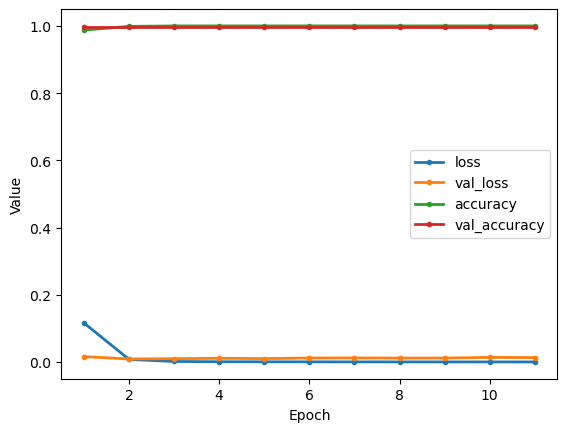

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

 6/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

11/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

16/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 1/22 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

 6/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

11/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

16/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [26]:
report.save()

Report saved as Output/Reports/YABBY/report_45SXHG4Z.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################